In [18]:
# Load the autoreload extension
%load_ext autoreload

# Autoreload reloads modules before executing code
# 0: disable
# 1: reload modules imported with %aimport
# 2: reload all modules, except those excluded by %aimport
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Defining the contracts


In [26]:
import pandas as pd


trade_date = pd.to_datetime('2021-06-17')

# Data from etrm R package by Anders Sleire
# Data in the same structure as the R data.frame
# tdate <- as.Date("2021-06-17")
data = {
    'Include': [True, True, True, True, True, True, True, True, True, True],
    'Contract': ["JUL-21", "AUG-21", "SEP-21", "OCT-21", "NOV-21", "DEC-21", "Q1-22", "Q2-22", "Q3-22", "Q4-22"],
    'From': ["2021-07-01", "2021-08-01", "2021-09-01", "2021-10-01", "2021-11-01", "2021-12-01", "2022-01-01", "2022-04-01", "2022-07-01", "2022-10-01"],
    'To': ["2021-08-01", "2021-09-01", "2021-10-01", "2021-11-01", "2021-12-01", "2022-01-01", "2022-04-01", "2022-07-01", "2022-10-01", "2022-12-31"],
    'Price': [32.55, 32.5, 32.5, 32.08, 36.88, 39.8, 39.4, 25.2, 21.15, 29.5],
}

# Create pandas DataFrame
df = pd.DataFrame(data)

# Convert 'From' and 'To' columns to datetime
df['From'] = pd.to_datetime(df['From'])
df['To'] = pd.to_datetime(df['To'])

# Calculate relative differences
df['Start_Diff'] = (df['From'] - trade_date).dt.days
df['End_Diff'] = (df['To'] - trade_date).dt.days

# Display the DataFrame
df

,Include,Contract,From,To,Price,Start_Diff,End_Diff
0,True,JUL-21,2021-07-01,2021-08-01,32.55,14,45
1,True,AUG-21,2021-08-01,2021-09-01,32.50,45,76
2,True,SEP-21,2021-09-01,2021-10-01,32.50,76,106
3,True,OCT-21,2021-10-01,2021-11-01,32.08,106,137
4,True,NOV-21,2021-11-01,2021-12-01,36.88,137,167
5,True,DEC-21,2021-12-01,2022-01-01,39.80,167,198
6,True,Q1-22,2022-01-01,2022-04-01,39.40,198,288
7,True,Q2-22,2022-04-01,2022-07-01,25.20,288,379
8,True,Q3-22,2022-07-01,2022-10-01,21.15,379,471
9,True,Q4-22,2022-10-01,2022-12-31,29.50,471,562


In [25]:
from curves import plot, builder
taus = (df[['Start_Diff', 'End_Diff']].values/365).tolist()


forward_prices = df['Price'].values.tolist()
knots = [0] + sorted(set(item for sublist in taus for item in sublist))

H = builder.calc_big_H(knots)
A = builder.calc_big_A(knots, taus)
B = builder.calc_B(forward_prices, knots,taus)
X = builder.solve_lineq(H, A, B)
taus


[[0.038356164383561646, 0.1232876712328767],
 [0.1232876712328767, 0.20821917808219179],
 [0.20821917808219179, 0.29041095890410956],
 [0.29041095890410956, 0.37534246575342467],
 [0.37534246575342467, 0.4575342465753425],
 [0.4575342465753425, 0.5424657534246575],
 [0.5424657534246575, 0.7890410958904109],
 [0.7890410958904109, 1.0383561643835617],
 [1.0383561643835617, 1.2904109589041095],
 [1.2904109589041095, 1.5397260273972602]]

In [28]:
from datetime import datetime, timedelta

# List to hold lists of daily dates for each row
list_of_daily_dates = []

# Loop through each row and create a list of dates for that row
for from_date, to_date in zip(df['From'], data['To']):
    # Convert the 'From' and 'To' dates to datetime objects
   
    # Generate the list of dates for the current row
    current_row_dates = [(start_date + timedelta(days=x)).strftime('%Y-%m-%d') 
                         for x in range((end_date - start_date).days)]
    
    # Append the list of dates for the current row to the main list
    list_of_daily_dates.append(current_row_dates)

# Now 'list_of_daily_dates' contains a list of lists with daily dates for each row

## Plotting

Polynomial([-12477.05671609,   7048.80071046,  -1355.08058219,    104.26557397,
           29.71769595], domain=[-1,  1], window=[-1,  1], symbol='x')

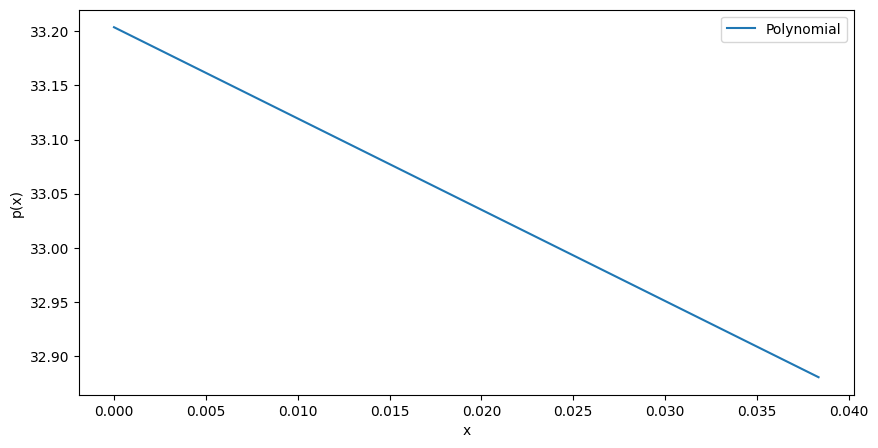

In [80]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
coef = X[0]
coef=coef[::-1]

p =Polynomial(coef)
x = np.linspace(0,0.038356164383561646,1000)

y = p(x)

# Plot the polynomial
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Polynomial')

# Label the axes
plt.xlabel('x')
plt.ylabel('p(x)')

# Add a legend
plt.legend()

#for i, coef in enumerate(X):
x = np.linspace(knots[1],knots[2], 10)
z = X[2]
y = Polynomial(z)

#plt.plot(x,y, label = 'Splines')
y


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

# Coefficients of the polynomials
coefficients = [
    [4.57186507e+04, -3.73527414e+03, 7.21819377e+01, 7.26156480e+00, 3.09070073e+01],
    [5.34491389e+03, -1.70028755e+03, 1.94405020e+02, -1.98297617e+00, 3.10543309e+01],
    [4887.52847044, -3652.98764629, 958.34969874, -97.8821751, 35.03061792],
    [-42247.38169627, 41102.32112185, -14737.12298992, 2319.20585692, -103.19796252],
    [-18392.73960677, 26511.69798733, -14096.48440018, 3301.6928688, -254.86554576],
    [26989.03251307, -45713.24092745, 28869.93575967, -8025.94514934, 862.14061838],
    [4288.58504886, -9358.08013358, 7481.08379801, -2588.27042074, 364.42785566],
    [-1684.9089764, 4506.5367292, -4535.26766323, 2023.08020651, -296.98189828],
    [-2437.76028669, 9022.02375587, -12411.69471704, 7498.23471897, -1639.75084993],
    [-405.48163826, 2099.85372564, -3995.67708253, 3309.83934287, -977.5630298],
    [874.61268361, -5037.76905763, 10846.34833019, -10341.28986892, 3711.16140349]
]

# Define the range for x values
x = np.linspace(-100, 100, 400)

# Plot each polynomial
plt.figure(figsize=(10, 8))

for i, coefs in enumerate(coefficients):
    # Evaluate the polynomial using NumPy's polyval
    y = np.polynomial.Polynomial(coefs[::-1],x)
    #y = np.polyval(coefs, x)
    # Plot the polynomial
    plt.plot(x, y, label=f'Polynomial {i+1}')

# Label the axes
plt.xlabel('x')
plt.ylabel('y')

# Create a legend
plt.legend()

# Show the plot
plt.show()

ValueError: Domain has wrong number of elements.

<Figure size 1000x800 with 0 Axes>

In [24]:
from datetime import datetime, timedelta

data = {
    'Include': [True, True, True, True, True, True, True, True, True, True],
    'Contract': ["JUL-21", "AUG-21", "SEP-21", "OCT-21", "NOV-21", "DEC-21", "Q1-22", "Q2-22", "Q3-22", "Q4-22"],
    'From': ["2021-07-01", "2021-08-01", "2021-09-01", "2021-10-01", "2021-11-01", "2021-12-01", "2022-01-01", "2022-04-01", "2022-07-01", "2022-10-01"],
    'To': ["2021-08-01", "2021-09-01", "2021-10-01", "2021-11-01", "2021-12-01", "2022-01-01", "2022-04-01", "2022-07-01", "2022-10-01", "2022-12-31"],
    'Price': [32.55, 32.5, 32.5, 32.08, 36.88, 39.8, 39.4, 25.2, 21.15, 29.5],
}

# List to hold lists of daily dates for each row
list_of_daily_dates = []

# Loop through each row and create a list of dates for that row
for from_date, to_date in zip(data['From'], data['To']):
    # Convert the 'From' and 'To' dates to datetime objects
    start_date = datetime.strptime(from_date, '%Y-%m-%d')
    end_date = datetime.strptime(to_date, '%Y-%m-%d')
    
    # Generate the list of dates for the current row
    current_row_dates = [(start_date + timedelta(days=x)).strftime('%Y-%m-%d') 
                         for x in range((end_date - start_date).days)]
    
    # Append the list of dates for the current row to the main list
    list_of_daily_dates.append(current_row_dates)

# Now 'list_of_daily_dates' contains a list of lists with daily dates for each row
list_of_daily_dates

[['2021-07-01',
  '2021-07-02',
  '2021-07-03',
  '2021-07-04',
  '2021-07-05',
  '2021-07-06',
  '2021-07-07',
  '2021-07-08',
  '2021-07-09',
  '2021-07-10',
  '2021-07-11',
  '2021-07-12',
  '2021-07-13',
  '2021-07-14',
  '2021-07-15',
  '2021-07-16',
  '2021-07-17',
  '2021-07-18',
  '2021-07-19',
  '2021-07-20',
  '2021-07-21',
  '2021-07-22',
  '2021-07-23',
  '2021-07-24',
  '2021-07-25',
  '2021-07-26',
  '2021-07-27',
  '2021-07-28',
  '2021-07-29',
  '2021-07-30',
  '2021-07-31'],
 ['2021-08-01',
  '2021-08-02',
  '2021-08-03',
  '2021-08-04',
  '2021-08-05',
  '2021-08-06',
  '2021-08-07',
  '2021-08-08',
  '2021-08-09',
  '2021-08-10',
  '2021-08-11',
  '2021-08-12',
  '2021-08-13',
  '2021-08-14',
  '2021-08-15',
  '2021-08-16',
  '2021-08-17',
  '2021-08-18',
  '2021-08-19',
  '2021-08-20',
  '2021-08-21',
  '2021-08-22',
  '2021-08-23',
  '2021-08-24',
  '2021-08-25',
  '2021-08-26',
  '2021-08-27',
  '2021-08-28',
  '2021-08-29',
  '2021-08-30',
  '2021-08-31'],
 ['202